In [2]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import psycopg2

%matplotlib inline

con = psycopg2.connect (user = 'postgres',
                password = 'postgres',
                port = '5432',
                host = 'localhost',                
                database = 'inicudb')

cur  = con.cursor()

In [3]:
uhid = "200600998"

In [4]:
cur1 = con.cursor()
cur1.execute("SELECT t1.uhid,t1.modificationtime,t1.pulserate, t1.ecg_resprate, t1.spo2, t1.heartrate,t1.mean_bp,t1.sys_bp,t1.dia_bp  FROM kalawati.device_monitor_detail AS t1 WHERE t1.uhid = '"+uhid+"'")
cols1 = list(map(lambda x: x[0], cur1.description))
ds = pd.DataFrame(cur1.fetchall(),columns=cols1)
ds.sort_values('modificationtime',inplace=True)

test = ds.drop_duplicates(subset=['uhid','modificationtime'],keep='first')

cur_vent = con.cursor()
cur_vent.execute("SELECT t1.uhid,t1.modificationtime,t1.creationtime,t1.peep, t1.pip,t1.map ,t1.tidalvol, t1.minvol,t1.ti,t1.fio2 FROM kalawati.device_ventilator_detail AS t1 WHERE t1.uhid = '"+uhid+"'")
cols_vent = list(map(lambda x: x[0], cur_vent.description))
ventilator_cont = pd.DataFrame(cur_vent.fetchall(),columns=cols_vent)

test_vent = ventilator_cont.drop_duplicates(subset=['uhid','modificationtime'],keep='first')

def split_date(x):
    try:
        t=str(x)
        return t.split(":")[0] + ":" + t.split(":")[1]
    except:
        pass
    
test['date'] = test.modificationtime.apply(split_date)
test_vent['date'] = test_vent.modificationtime.apply(split_date)

cont_data = pd.merge(test,test_vent,on=['uhid','date'],how='left',copy=False)
test_cont = cont_data.drop_duplicates(subset=['uhid','modificationtime_x','heartrate'],keep='first')

def split_date_hour(x):
    t = str(x)
    return t.split(":")[0]

cont_data.drop('modificationtime_y',axis=1,inplace=True)

#output
cur9= con.cursor()
cur9.execute("SELECT t1.uhid,t1.modificationtime,t1.creationtime,t1.abdomen_girth,t1.urine,t1.stool FROM kalawati.nursing_intake_output AS t1 WHERE t1.uhid = '"+uhid+"'")
cols9 = list(map(lambda x: x[0], cur9.description))
output = pd.DataFrame(cur9.fetchall(),columns=cols9)

#output.dropna(inplace=True)

output['date'] = output.modificationtime.apply(split_date)

test_med_cont = pd.merge(test_cont,output,on=['uhid','date'],how='left',copy=False)

#PN
cur8= con.cursor()
cur8.execute("SELECT t1.uhid,t1.modificationtime,t1.creationtime,t1.totalparenteralvolume FROM kalawati.babyfeed_detail AS t1 WHERE t1.uhid = '"+uhid+"'")
cols8 = list(map(lambda x: x[0], cur8.description))
pn = pd.DataFrame(cur8.fetchall(),columns=cols8)

pn['date'] = pn.modificationtime.apply(split_date)

test_med_cont_pn = pd.merge(test_med_cont,pn,on=['uhid','date'],how='left',copy=True)

cur = con.cursor()
cur.execute("SELECT uhid,creationtime,modificationtime,ph,entrydate FROM kalawati.nursing_bloodgas WHERE uhid = '"+uhid+"'")
cols = list(map(lambda x: x[0],cur.description))
ph = pd.DataFrame(cur.fetchall(),columns=cols)

def ph_func(x):
    try:
        p = float(x)
        if p>=6.90 and p<=7.45:
            return p
        else:
            return None
    except:
        pass
    
ph['new_ph'] = ph.ph.apply(ph_func)

ph.dropna(inplace=True)

ph['date'] = ph.modificationtime.apply(split_date)

test_med_cont_pn_ph = pd.merge(test_med_cont_pn,ph,on=['uhid','date'],how='left')

df = test_med_cont_pn_ph.ix[:,~test_med_cont_pn_ph.columns.duplicated()]

cur10 = con.cursor()
cur10 = con.cursor()
cur10.execute("SELECT t1.uhid,t1.gender,t1.birthweight,t1.birthlength,t1.birthheadcircumference,t1.inout_patient_status,t1.gestationweekbylmp,t1.gestationdaysbylmp,t1.baby_type,t1.central_temp,t2.apgar_onemin,t2.apgar_fivemin,t2.apgar_tenmin,t3.motherage,t4.conception_type,t4.mode_of_delivery,t5.steroidname,t5.numberofdose  FROM kalawati.baby_detail AS t1 LEFT JOIN kalawati.birth_to_nicu AS t2 ON t1.uhid=t2.uhid LEFT JOIN kalawati.parent_detail AS t3 ON t1.uhid=t3.uhid LEFT JOIN kalawati.antenatal_history_detail AS t4 ON t1.uhid=t4.uhid LEFT JOIN kalawati.antenatal_steroid_detail AS t5 ON t1.uhid=t5.uhid WHERE t1.uhid = '"+uhid+"'")
cols10 = list(map(lambda x: x[0], cur10.description))
fixed = pd.DataFrame(cur10.fetchall(),columns=cols10)

fixed.drop_duplicates(subset='uhid',keep='first',inplace=True)
test_med_cont_pn_ph_fixed = pd.merge(test_med_cont_pn_ph,fixed,on=['uhid'],how='left')

cur3 = con.cursor()
cur3.execute("SELECT t1.uhid,t1.modificationtime,t1.rbs,t1.skintemp,t1.centraltemp  FROM kalawati.nursing_vitalparameters AS t1 WHERE t1.uhid = '"+uhid+"'")
cols3 = list(map(lambda x: x[0], cur3.description))
nv = pd.DataFrame(cur3.fetchall(),columns=cols3)

nv.drop_duplicates(subset=['uhid','modificationtime'],keep='first',inplace=True)

nv['date'] = nv.modificationtime.apply(split_date)

test_med_cont_pn_ph_fixed_nv = pd.merge(test_med_cont_pn_ph_fixed,nv,on=['uhid','date'],how='left')

cur2 = con.cursor()
cur2.execute("SELECT t1.uhid,t1.visitdate,t1.currentdateweight, t1.currentdateheight  FROM kalawati.baby_visit AS t1 WHERE t1.uhid = '"+uhid+"'")
cols2 = list(map(lambda x: x[0], cur2.description))
bv = pd.DataFrame(cur2.fetchall(),columns=cols2)

def split_date_day(x):
    p = str(x)
    return p.split(" ")[0]

df = test_med_cont_pn_ph_fixed_nv.ix[:,~test_med_cont_pn_ph_fixed_nv.columns.duplicated()]

df['visitdate'] = df.modificationtime_x.apply(split_date_day)

def to_str(x):
    return str(x)
bv.visitdate = bv.visitdate.apply(to_str)

test_med_cont_pn_ph_fixed_nv_bv = pd.merge(df,bv,on=['uhid','visitdate'],how='left')

data = test_med_cont_pn_ph_fixed_nv_bv.drop_duplicates(subset=['uhid','modificationtime_x'],keep='first')

#Meds
cur7= con.cursor()
cur7.execute("SELECT t1.uhid,t1.modificationtime,t1.creationtime,t1.medicineorderdate,t1.medicinename,t1.medicationtype,t1.dose,t2.typevalue FROM kalawati.baby_prescription AS t1 LEFT JOIN kalawati.ref_medtype AS t2 ON t1.medicationtype = t2.typeid WHERE t2.typevalue = 'Antibiotics' OR t2.typevalue = 'Inotropes' OR t2.typevalue = 'Sedative' AND t1.uhid = '"+uhid+"'")
cols7 = list(map(lambda x: x[0], cur7.description))
meds = pd.DataFrame(cur7.fetchall(),columns=cols7)


meds_dummies = pd.get_dummies(meds,columns=['medicinename'])

meds_dummies['date'] = meds_dummies.creationtime.apply(split_date)

data_final = pd.merge(data,meds_dummies,on=['uhid','date'],how='left')

data = data_final.copy()





/home/inicuuser/.local/lib/python2.7/site-packages/ipykernel_launcher.py:80: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/inicuuser/.local/lib/python2.7/site-packages/ipykernel_launcher.py:111: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/inicuuser/.local/lib/python2.7/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
data = pd.read_csv('intermediate_checkpoint_10.csv')

In [4]:
data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,actual_DOB,uhid,dischargeddate,actual_DOA,gender,birthweight,birthlength,...,creationtime_y,peep,pip,map,tidalvol,minvol,ti,fio2,hour_series_y,ref_hour_y
0,0,0,0,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,3,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,4,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,5,5,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,6,6,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,7,7,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,8,8,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,9,9,2020-06-20 08:50:00.000,200600998,2020-06-22 15:40:23.330,2020-06-20 13:56:00.000,Male,1920.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
cols_to_use = [u'uhid', u'modificationtime_x', u'pulserate',
       u'ecg_resprate', u'spo2', u'heartrate', u'mean_bp',
       u'sys_bp', u'dia_bp', u'peep', u'pip', u'map', u'tidalvol', u'minvol', u'ti', u'fio2',
       u'creationtime_y', u'abdomen_girth', u'urine', u'stool',
       u'totalparenteralvolume', u'ph', u'entrydate', u'new_ph', u'gender',
       u'birthweight', u'birthlength', u'birthheadcircumference',
       u'inout_patient_status', u'gestationweekbylmp', u'gestationdaysbylmp',
       u'baby_type', u'central_temp', u'apgar_onemin', u'apgar_fivemin',
       u'apgar_tenmin', u'motherage', u'conception_type', u'mode_of_delivery',
       u'steroidname', u'numberofdose', u'rbs', u'skintemp', u'centraltemp',
       u'visitdate', u'currentdateweight', u'currentdateheight',
      
       u'dose', u'typevalue', u'medicinename_Amikacin',
       u'medicinename_Amoxicillin', u'medicinename_Ampicillin',
       u'medicinename_Azithromycin', u'medicinename_Cefoperazone + Sulbactam',
       u'medicinename_Cefotaxim', u'medicinename_Cefotaxim (Biotax)',
       u'medicinename_Ceftriaxone', u'medicinename_Ciprofloxacin',
       u'medicinename_Clarithromycin', u'medicinename_Colisitin',
       u'medicinename_Colistin (intraventricular)', u'medicinename_Dobutamine',
       u'medicinename_Dopamine', u'medicinename_Doputamine',
       u'medicinename_Epinephrine', u'medicinename_Gentamicin',
       u'medicinename_Linezolid', u'medicinename_Magnix',
       u'medicinename_Meropenem', u'medicinename_Metronidazole',
       u'medicinename_Midazolam', u'medicinename_Milrinone',
       u'medicinename_Morphine', u'medicinename_Netilmicin',
       u'medicinename_Ofloxacin', u'medicinename_Piperacilin Tazobactam',
       u'medicinename_Teicoplanin', u'medicinename_Tigecycline',
       u'medicinename_Vancomycin', u'medicinename_Vasopressin',
       u'medicinename_Zosyn (Piperacilin Tazobactam)',
       u'medicinename_levoflox']

In [6]:
data['medicinename_Midazolam'] = np.nan

In [7]:
data['medicinename_Morphine'] = np.nan

In [ ]:
'', u'', u'', u'', u'', u'', u'', u'', u'', u'', u'', 
u'', u'medicinename_Dopamine',
u'

In [18]:
data['medicinename_Meropenem'] = np.nan 
data['medicinename_Ceftriaxone'] = np.nan
data['medicinename_Cefotaxim (Biotax)'] = np.nan 
data['medicinename_Linezolid'] = np.nan
data['medicinename_Dopamine'] = np.nan 
data['medicinename_levoflox'] = np.nan
data['medicinename_Dobutamine'] = np.nan 
data['medicinename_Amikacin'] = np.nan
data['medicinename_Colisitin'] = np.nan 
data['medicinename_Vasopressin'] = np.nan
data['medicinename_Metronidazole'] = np.nan 
data['medicinename_Epinephrine'] = np.nan
data['medicinename_Vancomycin'] = np.nan 
data['medicinename_Doputamine'] = np.nan
data['medicinename_Amoxicillin'] = np.nan 
data['medicinename_Ampicillin'] = np.nan 
data['medicinename_Azithromycin'] = np.nan 
data['medicinename_Cefoperazone + Sulbactam'] = np.nan 
data['medicinename_Cefotaxim' 'medicinename_Ciprofloxacin'] = np.nan 
data['medicinename_Clarithromycin'] = np.nan 
data['medicinename_Colistin (intraventricular)'] = np.nan 
data['medicinename_Gentamicin'] = np.nan 
data['medicinename_Magnix'] = np.nan 
data['medicinename_Midazolam'] = np.nan 
data['medicinename_Milrinone'] = np.nan 
data['medicinename_Morphine'] =np.nan 
data['medicinename_Netilmicin'] = np.nan 
data['medicinename_Ofloxacin'] = np.nan 
data['medicinename_Piperacilin Tazobactam'] = np.nan 
data['medicinename_Teicoplanin'] = np.nan 
data['medicinename_Tigecycline'] = np.nan
data['medicinename_Cefotaxim'] = np.nan 
data['medicinename_Ciprofloxacin'] = np.nan
data['medicinename_Zosyn (Piperacilin Tazobactam)'] = np.nan
data['dose'] = np.nan

In [19]:
df = data.copy()

In [20]:
df = pd.get_dummies(df,columns=['stool'])
df = pd.get_dummies(df,columns=['steroidname'])
df = pd.get_dummies(df,columns=['mode_of_delivery'])

def conception(x):
    if x == 'ivf':
        return 1
    else:
        return 0
    
df.conception_type = df.conception_type.apply(conception)

def baby_type(x):
    if x == 'Twins' or x == 'Triplets':
        return 1
    else:
        return 0
df.baby_type = df.baby_type.apply(baby_type)

def gender(x):
    if x == 'Male':
        return 1
    else:
        return 0
    
df.gender = df.gender.apply(gender)

uhid = df.uhid.unique()

In [21]:
ds = pd.DataFrame(columns=df.columns)
for i in uhid:
    x = df[df['uhid']==i]
    x.currentdateweight.fillna(method='ffill',inplace=True)
    x.currentdateheight.fillna(method='ffill',inplace=True)
    x.central_temp.fillna(method='ffill',inplace=True)
    x.centraltemp.fillna(method='ffill',inplace=True)
    x.abdomen_girth.fillna(method='ffill',inplace=True)
    x.heartrate.fillna(method='ffill',limit=5,inplace=True)
    x.pulserate.fillna(method='ffill',limit=5,inplace=True)
    x.ecg_resprate.fillna(method='ffill',limit=5,inplace=True)
    x.spo2.fillna(method='ffill',limit=5,inplace=True)
    x.mean_bp.fillna(method='ffill',limit=5,inplace=True)
    x.sys_bp.fillna(method='ffill',limit=5,inplace=True)
    x.dia_bp.fillna(method='ffill',limit=5,inplace=True)
    x.minvol.fillna(method='ffill',limit=5,inplace=True)
    x.ti.fillna(method='ffill',limit=5,inplace=True)
    x.peep.fillna(method='ffill',limit=5,inplace=True)
    x.pip.fillna(method='ffill',limit=5,inplace=True)
    x.map.fillna(method='ffill',limit=5,inplace=True)
    x.tidalvol.fillna(method='ffill',limit=5,inplace=True)
    x.fio2.fillna(method='ffill',limit=5,inplace=True)
    x.rbs.fillna(method='ffill',limit=5,inplace=True)
    x.new_ph.fillna(method='ffill',limit=5,inplace=True)
    
    
    ds = ds.append(x,ignore_index=True)

In [22]:
import math
#ds.drop('skintemp',axis=1,inplace=True)
dt = df.fillna(-999)

def range_finder(x):
    length = x
    fractional = (x/15.0) - math.floor(x/15.0)
    return int(round(fractional*15))
    
final_df = dt[range_finder(len(dt)):len(dt)]

In [23]:
def in_out(x):
    if x == 'Out Born':
        return 1
    else:
        return 0
final_df.inout_patient_status = final_df.inout_patient_status.apply(in_out)
cols_to_use_2 = [ u'pulserate', u'ecg_resprate', u'spo2',
       u'heartrate', u'mean_bp', u'sys_bp', u'dia_bp',
       u'peep', u'pip', u'map', u'tidalvol', u'minvol', u'ti', u'fio2',
       u'abdomen_girth', u'urine', u'totalparenteralvolume',
       u'new_ph', u'gender', u'birthweight',
       u'birthlength', u'birthheadcircumference', u'inout_patient_status',
       u'gestationweekbylmp', u'gestationdaysbylmp', u'baby_type',
       u'central_temp', u'apgar_onemin', u'apgar_fivemin', u'apgar_tenmin',
       u'motherage', u'conception_type', u'numberofdose', u'rbs',
       u'centraltemp', u'currentdateweight',
       u'currentdateheight', u'dose', u'medicinename_Amikacin',
       u'medicinename_Amoxicillin', u'medicinename_Ampicillin',
       u'medicinename_Azithromycin', u'medicinename_Cefoperazone + Sulbactam',
       u'medicinename_Cefotaxim', u'medicinename_Cefotaxim (Biotax)',
       u'medicinename_Ceftriaxone', u'medicinename_Ciprofloxacin',
       u'medicinename_Clarithromycin', u'medicinename_Colisitin',
       u'medicinename_Colistin (intraventricular)', u'medicinename_Dobutamine',
       u'medicinename_Dopamine', u'medicinename_Doputamine',
       u'medicinename_Epinephrine', u'medicinename_Gentamicin',
       u'medicinename_Linezolid', u'medicinename_Magnix',
       u'medicinename_Meropenem', u'medicinename_Metronidazole',
       u'medicinename_Midazolam', u'medicinename_Milrinone',
       u'medicinename_Morphine', u'medicinename_Netilmicin',
       u'medicinename_Ofloxacin', u'medicinename_Piperacilin Tazobactam',
       u'medicinename_Teicoplanin', u'medicinename_Tigecycline',
       u'medicinename_Vancomycin', u'medicinename_Vasopressin',
       u'medicinename_Zosyn (Piperacilin Tazobactam)',
       u'medicinename_levoflox', u'stool_Large', u'stool_Medium',
       u'stool_Small', u'steroidname_Beta', u'steroidname_Dexa',
       u'mode_of_delivery_Forceps', u'mode_of_delivery_LSCS',
       u'mode_of_delivery_NVD', u'mode_of_delivery_Vaccum']

In [81]:
#gd['steroidname_Dexa'] = 0

In [24]:
gd = final_df.copy()
gd['stool_Large'] = 0
gd['stool_Medium'] = 0
gd['stool_Small'] = 0
gd['steroidname_Dexa'] = 0
gd['steroidname_Beta'] = 0
gd['mode_of_delivery_Forceps'] = 0
gd['mode_of_delivery_LSCS'] = 1
gd['mode_of_delivery_NVD'] = 0
gd['mode_of_delivery_Vaccum'] = 0
#gd['spo2'] = 30
gd = gd[cols_to_use_2]
X_test = gd[:]
X_test = np.array(X_test)
Xtest = np.reshape(X_test, (-1, 15, X_test.shape[1]))

In [25]:
import tensorflow as tf
new_model = tf.keras.models.load_model('LSTM_30_DEC.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
y_pred = new_model.predict(Xtest)

In [27]:
Xtest[0][0]

array([-9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
       -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
       -9.99e+02, -9.99e+02,  2.50e+01, -9.99e+02, -9.99e+02, -9.99e+02,
        1.00e+00,  1.92e+03,  4.20e+01,  3.00e+01,  1.00e+00,  3.60e+01,
        0.00e+00,  0.00e+00, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
        2.70e+01,  0.00e+00, -9.99e+02, -9.99e+02, -9.99e+02,  1.92e+03,
        4.20e+01,  4.00e+01, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
       -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
       -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
       -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
       -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02, -9.99e+02,
       -9.99e+02, -9.99e+02, -9.99e+02,  1.00e+00, -9.99e+02,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  1.00e+00,
        0.00e+00,  0.00e+00])

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
print(y_df[0].to_string())

0      0.026664
1      0.026570
2      0.026570
3      0.026570
4      0.026570
5      0.026570
6      0.026570
7      0.026570
8      0.025261
9      0.025272
10     0.025272
11     0.025272
12     0.025272
13     0.025272
14     0.025272
15     0.025272
16     0.011838
17     0.011632
18     0.011632
19     0.011632
20     0.025078
21     0.023098
22     0.023098
23     0.023098
24     0.023098
25     0.023098
26     0.023098
27     0.023098
28     0.023098
29     0.023098
30     0.023098
31     0.023098
32     0.023098
33     0.023098
34     0.023098
35     0.023098
36     0.023098
37     0.023098
38     0.023098
39     0.023098
40     0.012738
41     0.012521
42     0.012521
43     0.012521
44     0.026031
45     0.023821
46     0.023821
47     0.023821
48     0.012583
49     0.012521
50     0.012521
51     0.012521
52     0.026031
53     0.023821
54     0.023821
55     0.023821
56     0.012583
57     0.012521
58     0.012521
59     0.012521
60     0.026031
61     0.023821
62     0

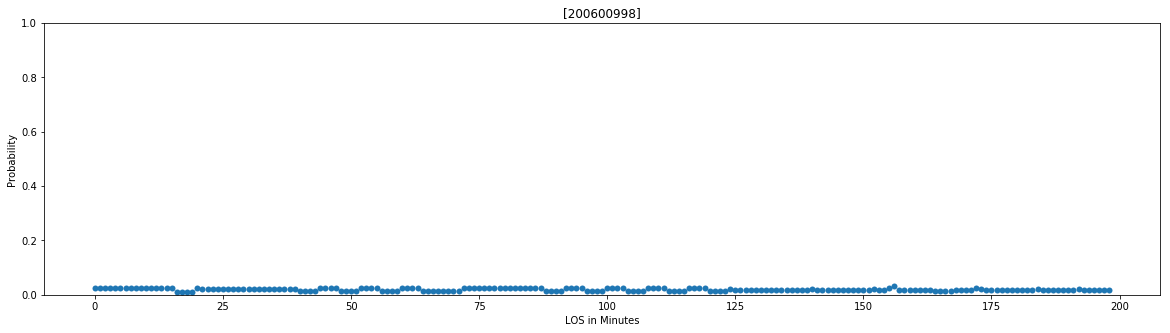

In [29]:
y_df = pd.DataFrame(y_pred)
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
axes = plt.gca()



sns.scatterplot(y = y_df[0], x = np.arange(len(y_pred)),linewidth=0)
plt.title(uhid)
plt.xlabel('LOS in Minutes')
plt.ylabel('Probability')
axes.set_ylim([0,1])
plt.savefig('kalawati.png',dpi = 300)


In [ ]:
#gd.to_csv('check_191201527.csv')

In [ ]:
#con.close()

In [21]:
Xtest[0][0]

array(['174', '69', '97', '174', '35', '57', '29', -999.0, -999.0, -999.0,
       -999.0, -999.0, -999.0, -999.0, -999.0, -999, -999.0, -999.0, 1,
       1920.0, 42.0, 30.0, 1, 36, 0, 0, -999, -999, -999, -999, 27, 0,
       -999, -999.0, -999, 1800.0, -999.0, 40, -999.0, -999.0, -999.0,
       -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0,
       -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0,
       -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0, -999.0,
       -999.0, -999.0, -999.0, -999.0, 1, -999.0, 0, 0, 0, 0, 0, 0, 1, 0,
       0], dtype=object)

In [26]:
ds

,uhid,modificationtime_x,pulserate,ecg_resprate,spo2,heartrate,mean_bp,sys_bp,dia_bp,peep,...,medicinename_Netilmicin,medicinename_Ofloxacin,medicinename_Piperacilin Tazobactam,medicinename_Teicoplanin,medicinename_Tigecycline,medicinename_Vancomycin,medicinename_Vasopressin,medicinename_Zosyn (Piperacilin Tazobactam),medicinename_levoflox,mode_of_delivery_LSCS
0,200600998,2020-06-22 10:22:55.897355,171,50,97,171,36,57,26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
1,200600998,2020-06-22 10:23:56.076638,170,57,97,170,36,57,26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
2,200600998,2020-06-22 10:24:56.253066,172,70,96,173,36,57,26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
3,200600998,2020-06-22 10:25:56.447920,173,72,97,173,35,56,28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
4,200600998,2020-06-22 10:26:56.618751,174,69,97,174,35,57,29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
5,200600998,2020-06-22 10:27:56.819212,174,78,97,176,35,57,29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
6,200600998,2020-06-22 10:28:50.898007,175,60,97,178,35,57,29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
7,200600998,2020-06-22 10:29:57.198823,175,50,97,175,35,57,29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
8,200600998,2020-06-22 10:30:54.152969,173,70,97,174,35,57,29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1
9,200600998,2020-06-22 10:31:57.628873,174,80,97,174,35,57,29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,1


In [ ]:
#gd.to_csv('check_191201625.csv')

In [27]:
data

,uhid,modificationtime_x,pulserate,ecg_resprate,spo2,heartrate,mean_bp,sys_bp,dia_bp,date,...,medicinename_Gentamicin,medicinename_Magnix,medicinename_Milrinone,medicinename_Netilmicin,medicinename_Ofloxacin,medicinename_Piperacilin Tazobactam,medicinename_Teicoplanin,medicinename_Tigecycline,medicinename_Cefotaxim,medicinename_Ciprofloxacin
0,200600998,2020-06-22 10:22:55.897355,171,50,97,171,36,57,26,2020-06-22 10:22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200600998,2020-06-22 10:23:56.076638,170,57,97,170,36,57,26,2020-06-22 10:23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200600998,2020-06-22 10:24:56.253066,172,70,96,173,36,57,26,2020-06-22 10:24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200600998,2020-06-22 10:25:56.447920,173,72,97,173,35,56,28,2020-06-22 10:25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200600998,2020-06-22 10:26:56.618751,174,69,97,174,35,57,29,2020-06-22 10:26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,200600998,2020-06-22 10:27:56.819212,174,78,97,176,35,57,29,2020-06-22 10:27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,200600998,2020-06-22 10:28:50.898007,175,60,97,178,35,57,29,2020-06-22 10:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,200600998,2020-06-22 10:29:57.198823,175,50,97,175,35,57,29,2020-06-22 10:29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,200600998,2020-06-22 10:30:54.152969,173,70,97,174,35,57,29,2020-06-22 10:30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,200600998,2020-06-22 10:31:57.628873,174,80,97,174,35,57,29,2020-06-22 10:31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
len(Xtest)

1

In [25]:
len(Xtest[0])

15

In [28]:
y_pred

array([[0.17820264]], dtype=float32)

In [29]:
dp = pd.read_csv('intermediate_checkpoint_10.csv')

In [40]:
s = set(cols_to_use_2) - set(dp.columns).intersection(set(cols_to_use_2))

In [44]:
for i in list(s):
    dp[i] = np.nan

In [71]:
#dp.baby_type = 1

In [70]:
dp.baby_type = 0

In [78]:
dp.conception_type = 0

In [90]:
len(dp)

62

In [93]:
dp.hour_series_y

0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
5                     NaN
6                     NaN
7                     NaN
8                     NaN
9                     NaN
10                    NaN
11                    NaN
12                    NaN
13                    NaN
14                    NaN
15                    NaN
16                    NaN
17                    NaN
18                    NaN
19    2020-06-20 13:56:00
20    2020-06-20 14:56:00
21    2020-06-20 15:56:00
22    2020-06-20 16:56:00
23    2020-06-20 17:56:00
24    2020-06-20 18:56:00
25    2020-06-20 19:56:00
26    2020-06-20 20:56:00
27    2020-06-20 21:56:00
28    2020-06-20 22:56:00
29    2020-06-20 23:56:00
             ...         
32    2020-06-21 02:56:00
33    2020-06-21 03:56:00
34    2020-06-21 04:56:00
35    2020-06-21 05:56:00
36    2020-06-21 06:56:00
37    2020-06-21 07:56:00
38    2020-06-21 08:56:00
39    2020-0